In [ ]:
import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/XRAYIMAGE.zip'

# Specify the directory where you want to extract the files
extract_to_dir = '/content/unzip1'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Print a message indicating the extraction directory
print(f"Files extracted to {extract_to_dir}")

Files extracted to /content/unzip1


In [ ]:
import cv2
import os

# Input and Output folders
input_folder = '/content/unzip1/XRAYIMAGE'   # Your folder with input images
output_folder = '/content/masks'             # Where to save thresholded images

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Supported image extensions
image_extensions = ['.png', '.jpg', '.jpeg']

# Process each image in folder
for filename in os.listdir(input_folder):
    if any(filename.lower().endswith(ext) for ext in image_extensions):

        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert to grayscale and apply Otsu threshold
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Save mask
        output_path = os.path.join(output_folder, f"mask_{filename}")
        cv2.imwrite(output_path, mask)

print("Masks saved successfully!")


Masks saved successfully!


In [ ]:
import os
import math
import random
from pathlib import Path

import tensorflow as tf


# ---------------- CONFIG ----------------
INPUT_IMAGE_DIR = "/content/unzip1/XRAYIMAGE"       # 247 images
INPUT_MASK_DIR  = "/content/masks"        # 247 masks

OUTPUT_IMAGE_DIR = "data_aug/images"  # augmented images will be saved here
OUTPUT_MASK_DIR  = "data_aug/masks"   # augmented masks will be saved here

TARGET_TOTAL = 600   # final desired count (original + augmented)


# --------- CREATE OUTPUT FOLDERS ----------
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)


# --------- LIST INPUT FILES ----------
image_paths = sorted(list(Path(INPUT_IMAGE_DIR).glob("*.*")))
mask_paths  = sorted(list(Path(INPUT_MASK_DIR).glob("*.*")))

assert len(image_paths) == len(mask_paths), "Images and masks count must match!"
original_count = len(image_paths)
print(f"Found {original_count} original image–mask pairs.")

if original_count >= TARGET_TOTAL:
    raise ValueError("You already have >= TARGET_TOTAL images. No need to augment.")

needed_aug = TARGET_TOTAL - original_count
print(f"Need to create {needed_aug} augmented pairs.")


# --------- HELPER: LOAD IMAGE & MASK ----------
def load_image(path):
    img_bytes = tf.io.read_file(str(path))
    img = tf.io.decode_png(img_bytes, channels=3)  # change channels if needed
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    return img

def load_mask(path):
    mask_bytes = tf.io.read_file(str(path))
    # assume mask is single-channel PNG
    mask = tf.io.decode_png(mask_bytes, channels=1)
    # keep as float32 in [0,1] if mask is 0/1
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    return mask


# --------- HELPER: SAVE IMAGE & MASK ----------
def save_image_mask(img, mask, img_out_path, mask_out_path):
    """
    img, mask: float32 tensors in [0,1]
    """
    # convert to uint8 [0,255]
    img_uint8 = tf.image.convert_image_dtype(img, tf.uint8)
    mask_uint8 = tf.image.convert_image_dtype(mask, tf.uint8)

    img_png = tf.io.encode_png(img_uint8)
    mask_png = tf.io.encode_png(mask_uint8)

    tf.io.write_file(str(img_out_path), img_png)
    tf.io.write_file(str(mask_out_path), mask_png)


# --------- HELPER: RANDOM AUGMENTATION (same for image & mask) ----------
def augment_image_and_mask(img, mask):
    """
    Apply the SAME random transforms to image and mask:
    - random horizontal flip
    - random vertical flip
    - random 90-degree rotation
    - random zoom (center crop + resize)
    - random brightness ONLY to the image
    """

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Random 0, 90, 180, 270 rotation
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # Random zoom: random central crop then resize back
    if tf.random.uniform(()) > 0.5:
        # zoom factor between 0.8 and 1.0 (less than full size)
        zoom = tf.random.uniform((), 0.8, 1.0)
        orig_shape = tf.shape(img)
        h = tf.cast(orig_shape[0], tf.float32)
        w = tf.cast(orig_shape[1], tf.float32)

        crop_h = tf.cast(zoom * h, tf.int32)
        crop_w = tf.cast(zoom * w, tf.int32)

        img = tf.image.resize_with_crop_or_pad(img, crop_h, crop_w)
        mask = tf.image.resize_with_crop_or_pad(mask, crop_h, crop_w)

        img = tf.image.resize(img, (orig_shape[0], orig_shape[1]),
                              method="bilinear")
        # for masks, use NEAREST to keep labels intact
        mask = tf.image.resize(mask, (orig_shape[0], orig_shape[1]),
                               method="nearest")

    # Random brightness (only image)
    img = tf.image.random_brightness(img, max_delta=0.1)

    # Clip back to [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)
    mask = tf.clip_by_value(mask, 0.0, 1.0)

    return img, mask


# --------- MAIN AUGMENTATION LOOP ----------
augmented_created = 0
pair_index = 0

while augmented_created < needed_aug:
    img_path = image_paths[pair_index % original_count]
    mask_path = mask_paths[pair_index % original_count]

    img = load_image(img_path)
    mask = load_mask(mask_path)

    img_aug, mask_aug = augment_image_and_mask(img, mask)

    # Build output filenames
    stem = img_path.stem  # base name without extension
    aug_id = augmented_created + 1
    img_out_name = f"{stem}_aug{aug_id:03d}.png"
    mask_out_name = f"{stem}_aug{aug_id:03d}.png"

    img_out_path = Path(OUTPUT_IMAGE_DIR) / img_out_name
    mask_out_path = Path(OUTPUT_MASK_DIR) / mask_out_name

    save_image_mask(img_aug, mask_aug, img_out_path, mask_out_path)

    augmented_created += 1
    pair_index += 1

    if augmented_created % 50 == 0 or augmented_created == needed_aug:
        print(f"Created {augmented_created}/{needed_aug} augmented pairs.")

print("Done")
print(f"Original pairs: {original_count}")
print(f"Augmented pairs created: {augmented_created}")
print(f"Total pairs (original + augmented): {original_count + augmented_created}")

Found 247 original image–mask pairs.
Need to create 353 augmented pairs.
Created 50/353 augmented pairs.
Created 100/353 augmented pairs.
Created 150/353 augmented pairs.
Created 200/353 augmented pairs.
Created 250/353 augmented pairs.
Created 300/353 augmented pairs.
Created 350/353 augmented pairs.
Created 353/353 augmented pairs.
Done
Original pairs: 247
Augmented pairs created: 353
Total pairs (original + augmented): 600


Starting Lung Nodule Segmentation with Fractal-Fractional UNet...
Creating data generators...
Creating train/val/test splits...
Training samples: 247
Validation samples: 52
Test samples: 54
Building fractal_fractional_unet...


Model: "Fractal_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_conv1 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_bn1              │ (None, 256, 256,  │        256 │ e1_conv1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_act1             │ (None, 256, 256,  │          0 │ e1_bn1[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_conv2 (Conv2D)   │ (None, 256, 256,  │     36,928 │ e1_act1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_bn2              │ (None, 256, 256,  │        256 │ e1_conv2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_act2             │ (None, 256, 256,  │          0 │ e1_bn2[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e1_fractal_att      │ (None, 256, 256,  │     45,248 │ e1_act2[0][0]     │
│ (FractalAttentionE… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (MaxPooling2D)   │ (None, 128, 128,  │          0 │ e1_fractal_att[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_conv1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ p1[0][0]          │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_bn1              │ (None, 128, 128,  │        512 │ e2_conv1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_act1             │ (None, 128, 128,  │          0 │ e2_bn1[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_conv2 (Conv2D)   │ (None, 128, 128,  │    147,584 │ e2_act1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_bn2              │ (None, 128, 128,  │        512 │ e2_conv2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_act2             │ (None, 128, 128,  │          0 │ e2_bn2[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ e2_fractal_att      │ (None, 128, 128,  │    180,608 │ e2_act2[0][0]     │
│ (FractalAttentionE… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (MaxPooling2D)   │ (None, 64, 64,    │          0 │ e2_fractal_att[0

 Total params: 54,091,589 (206.34 MB)

 Trainable params: 54,079,813 (206.30 MB)

 Non-trainable params: 11,776 (46.00 KB)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7582 - dice_coefficient: 0.8055 - iou_metric: 0.7005 - loss: 0.4674 - precision: 0.8463 - recall: 0.7733
Epoch 1: val_iou_metric improved from -inf to 0.60165, saving model to best_fractal_fractional_unet.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 296s 11s/step - accuracy: 0.7637 - dice_coefficient: 0.8107 - iou_metric: 0.7075 - loss: 0.4578 - precision: 0.8500 - recall: 0.7796 - val_accuracy: 0.6150 - val_dice_coefficient: 0.7507 - val_iou_metric: 0.6017 - val_loss: 0.6664 - val_precision: 0.6017 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9196 - dice_coefficient: 0.9527 - iou_metric: 0.9097 - loss: 0.1478 - precision: 0.9540 - recall: 0.9534
Epoch 2: val_iou_metric did not improve from 0.60165
16/16 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.9197 - dice_coefficient: 0.9528 - iou_metric: 0.9099 - loss: 0.1474 - precision: 0.9539 - recall: 0.9537 - val_accuracy:

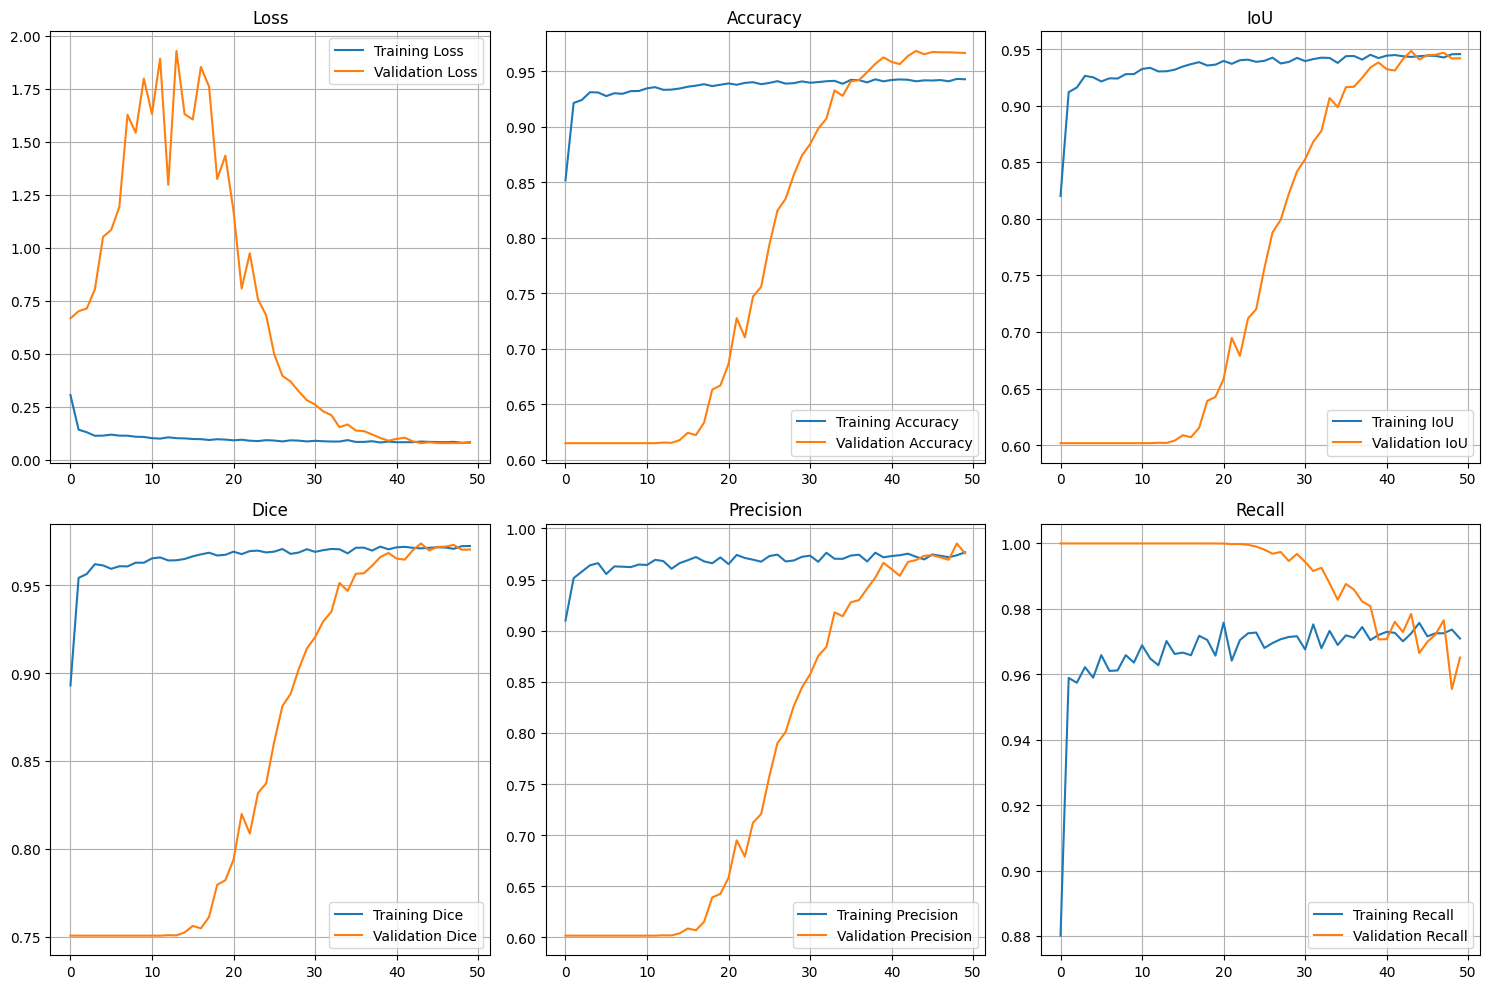

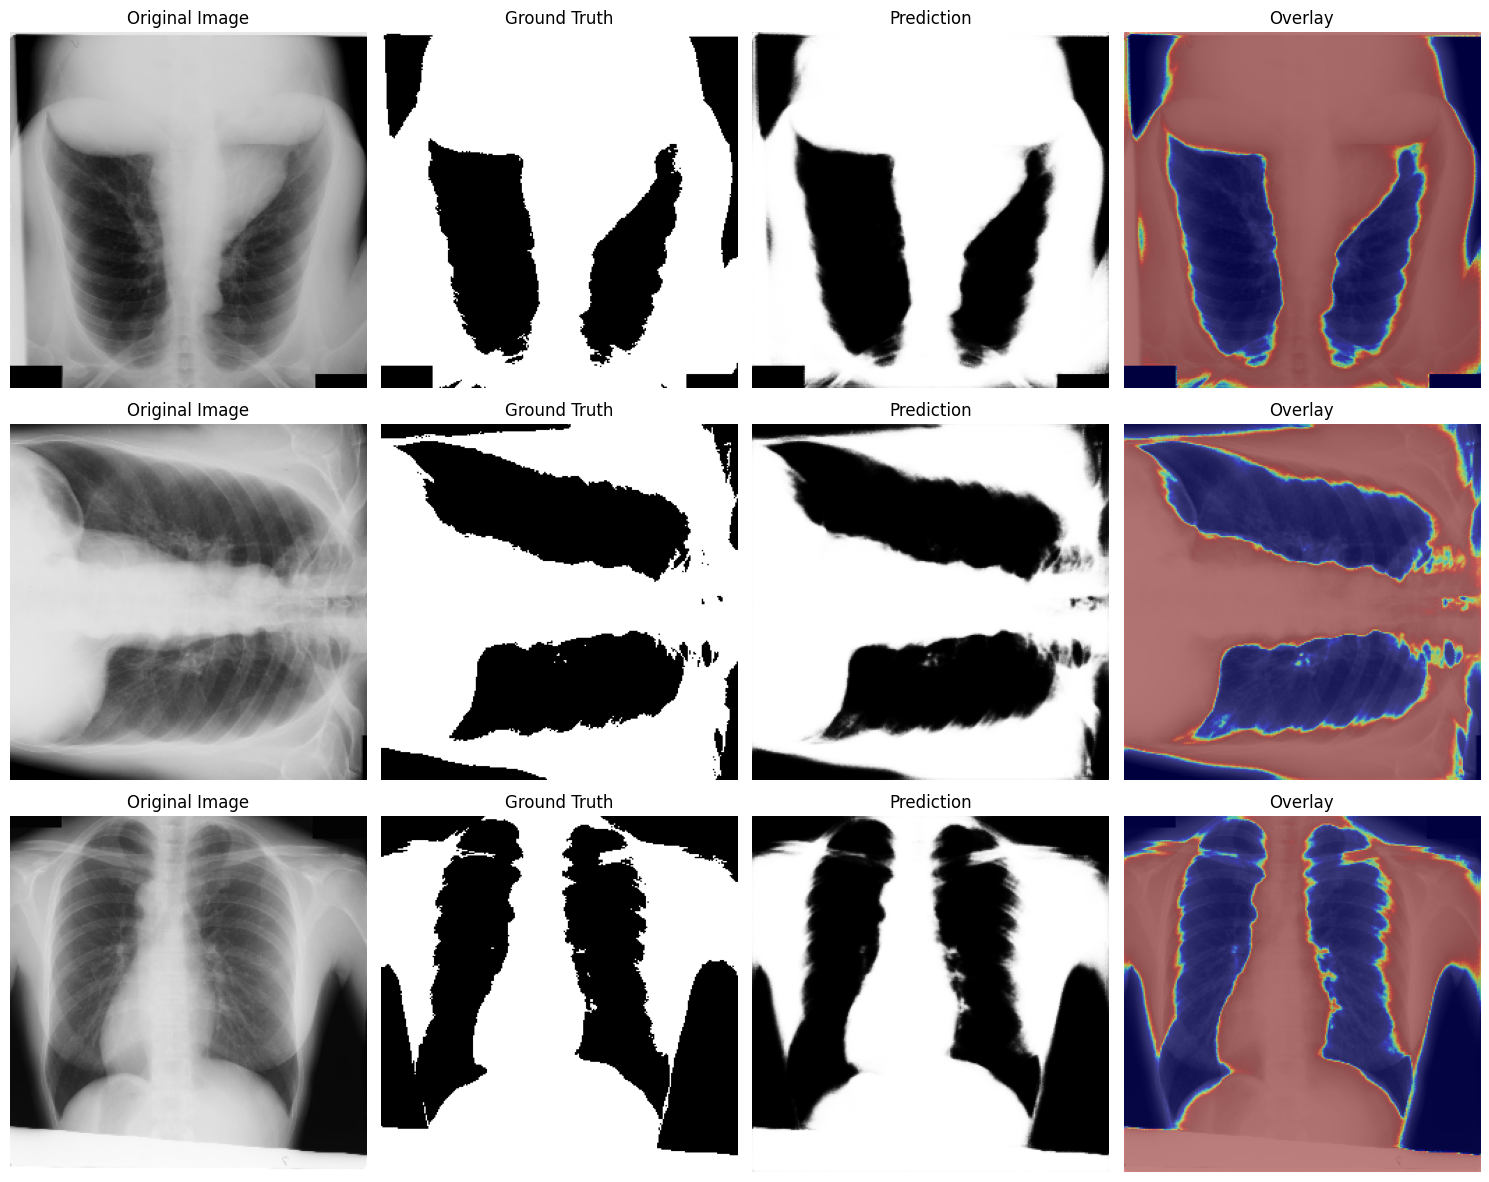


EXECUTION SUMMARY
Start Time: Wed Dec  3 01:40:33 2025
End Time: Wed Dec  3 02:37:05 2025
Total Time: 3392.28 seconds (56.54 minutes)
Training Samples: 247
Validation Samples: 52
Test Samples: 54
Model Parameters: 54,091,589


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

# ------------------------- #
# Enhanced Fractal-Fractional Layer
# ------------------------- #
class EnhancedFractalFractionalLayer(layers.Layer):
    def __init__(self, output_channels, alpha=2.0, beta=0.5, kernel_size=3, use_bias=True, **kwargs):
        super().__init__(**kwargs)
        self.output_channels = output_channels
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.kernel_size = int(kernel_size)
        self.use_bias = use_bias

    def build(self, input_shape):
        # input_shape: (batch, H, W, in_channels)
        in_channels = int(input_shape[-1])
        out_channels = self.output_channels

        # Create base radial mask for a standard convolution kernel
        base_mask = np.zeros(
            (self.kernel_size, self.kernel_size, in_channels, out_channels),
            dtype=np.float32
        )

        center = self.kernel_size // 2
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                distance = np.sqrt((i - center) ** 2 + (j - center) ** 2)
                if distance == 0:
                    weight = 1.0
                else:
                    weight = (1 + distance ** self.alpha) ** (-self.beta)

                # Apply weight diagonally for channel-wise operation
                # Assuming 1:1 mapping of input to output channels if not specified
                for c_in in range(min(in_channels, out_channels)):
                    base_mask[i, j, c_in, c_in] = weight

        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, self.kernel_size, in_channels, out_channels),
            initializer=tf.constant_initializer(base_mask),
            trainable=True,
            dtype=self.dtype
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(out_channels,),
                initializer='zeros',
                trainable=True,
                dtype=self.dtype
            )

        super().build(input_shape)

    def call(self, inputs):
        # Use layer's compute dtype (handles mixed precision)
        x = tf.cast(inputs, self.compute_dtype)

        # Use standard convolution (tf.nn.conv2d)
        x = tf.nn.conv2d(
            x,
            filters=tf.cast(self.kernel, self.compute_dtype),
            strides=[1, 1, 1, 1],
            padding='SAME'
        )

        if self.use_bias:
            x = tf.nn.bias_add(x, tf.cast(self.bias, self.compute_dtype))

        # Activation
        x = tf.nn.relu(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'output_channels': self.output_channels,
                'alpha': self.alpha,
                'beta': self.beta,
                'kernel_size': self.kernel_size,
                'use_bias': self.use_bias
            }
        )
        return config

# ------------------------- #
# Fractal Attention Block for Encoder
# ------------------------- #
class FractalAttentionEncoder(layers.Layer):
    def __init__(self, filters, alpha=2.0, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.alpha = alpha
        self.beta = beta

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(self.filters, 1, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(self.filters, 1, padding='same', activation='relu')
        # Pass filters as output_channels to EnhancedFractalFractionalLayer
        self.ff_layer = EnhancedFractalFractionalLayer(output_channels=self.filters, alpha=self.alpha, beta=self.beta)
        self.conv_attention = layers.Conv2D(self.filters, 1, padding='same', activation='sigmoid')
        self.multiply = layers.Multiply()
        super().build(input_shape)

    def call(self, inputs):
        x_conv = self.conv1(inputs)
        x_ff = self.ff_layer(x_conv)
        attention = self.conv_attention(x_ff)

        # Apply attention and residual
        output = self.multiply([inputs, attention])
        output = layers.Add()([inputs, output])
        return output

# ------------------------- #
# Fractal Attention Block for Decoder
# ------------------------- #
class FractalAttentionDecoder(layers.Layer):
    def __init__(self, filters, alpha=2.0, beta=0.5, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.alpha = alpha
        self.beta = beta

    def build(self, input_shape):
        # input_shape is expected to be a list of shapes: [g_shape, x_shape]
        g_shape, x_shape = input_shape

        self.g_conv = layers.Conv2D(self.filters, 1, padding='same', activation='relu', name=f'{self.name}_g_conv')
        self.x_conv = layers.Conv2D(self.filters, 1, padding='same', activation='relu', name=f'{self.name}_x_conv')

        # Pass filters as output_channels to EnhancedFractalFractionalLayer
        self.ff_layer = EnhancedFractalFractionalLayer(output_channels=self.filters, alpha=self.alpha, beta=self.beta, name=f'{self.name}_ff_layer')
        self.conv_attention = layers.Conv2D(1, 1, padding='same', activation='sigmoid', name=f'{self.name}_conv_attention')

        self.add_layer = layers.Add(name=f'{self.name}_add_layer')
        self.relu_activation = layers.Activation('relu', name=f'{self.name}_relu_activation')
        self.multiply_layer = layers.Multiply(name=f'{self.name}_multiply_layer')

        super().build(input_shape)

    def call(self, inputs):
        g, x = inputs  # g: upsampled decoder feature, x: encoder skip

        g_conv = self.g_conv(g)
        x_conv = self.x_conv(x)

        combined = self.add_layer([g_conv, x_conv])
        combined = self.relu_activation(combined)
        combined_ff = self.ff_layer(combined)

        attention = self.conv_attention(combined_ff)
        attended_x = self.multiply_layer([x, attention])
        return attended_x

# ------------------------- #
# Enhanced Nested Skip Block with Fractal Attention
# ------------------------- #
def enhanced_nested_skip_block(inputs, filters, use_fractal_attention=True, name=None):
    x = layers.Conv2D(filters, 3, padding='same', name=f'{name}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.Activation('relu', name=f'{name}_act1')(x)

    x = layers.Conv2D(filters, 3, padding='same', name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = layers.Activation('relu', name=f'{name}_act2')(x)

    if use_fractal_attention:
        x = FractalAttentionEncoder(filters=filters, name=f'{name}_fractal_att')(x)

    return x

# ------------------------- #
# Complete U-Net with Fractal Attention in Both Encoder & Decoder
# ------------------------- #
def build_fractal_unet(input_shape=(256, 256, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = enhanced_nested_skip_block(inputs, 64, use_fractal_attention=True, name='e1')
    p1 = layers.MaxPooling2D((2, 2), name='p1')(e1)

    e2 = enhanced_nested_skip_block(p1, 128, use_fractal_attention=True, name='e2')
    p2 = layers.MaxPooling2D((2, 2), name='p2')(e2)

    e3 = enhanced_nested_skip_block(p2, 256, use_fractal_attention=True, name='e3')
    p3 = layers.MaxPooling2D((2, 2), name='p3')(e3)

    e4 = enhanced_nested_skip_block(p3, 512, use_fractal_attention=True, name='e4')
    p4 = layers.MaxPooling2D((2, 2), name='p4')(e4)

    # Bridge
    bridge = enhanced_nested_skip_block(p4, 1024, use_fractal_attention=True, name='bridge')

    # Decoder
    u1 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', name='u1')(bridge)
    att1 = FractalAttentionDecoder(filters=512, name='att1')([u1, e4])
    c1 = layers.Concatenate(name='cat1')([u1, att1])
    d1 = enhanced_nested_skip_block(c1, 512, use_fractal_attention=True, name='d1')

    u2 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name='u2')(d1)
    att2 = FractalAttentionDecoder(filters=256, name='att2')([u2, e3])
    c2 = layers.Concatenate(name='cat2')([u2, att2])
    d2 = enhanced_nested_skip_block(c2, 256, use_fractal_attention=True, name='d2')

    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='u3')(d2)
    att3 = FractalAttentionDecoder(filters=128, name='att3')([u3, e2])
    c3 = layers.Concatenate(name='cat3')([u3, att3])
    d3 = enhanced_nested_skip_block(c3, 128, use_fractal_attention=True, name='d3')

    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='u4')(d3)
    att4 = FractalAttentionDecoder(filters=64, name='att4')([u4, e1])
    c4 = layers.Concatenate(name='cat4')([u4, att4])
    d4 = enhanced_nested_skip_block(c4, 64, use_fractal_attention=True, name='d4')

    # Output
    if num_classes == 1:
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid', name='output')(d4)
    else:
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', name='output')(d4)

    model = Model(inputs=inputs, outputs=outputs, name='Fractal_UNet')
    return model

# ------------------------- #
# Enhanced Metrics
# ------------------------- #
class EnhancedMetrics:
    @staticmethod
    def iou_metric(y_true, y_pred, smooth=1e-6):
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
        return (intersection + smooth) / (union + smooth)

    @staticmethod
    def dice_coefficient(y_true, y_pred, smooth=1e-6):
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

    @staticmethod
    def precision(y_true, y_pred):
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
        true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_f, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    @staticmethod
    def recall(y_true, y_pred):
        y_true_f = K.flatten(K.cast(y_true, 'float32'))
        y_pred_f = K.flatten(K.cast(y_pred > 0.5, 'float32'))
        true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_f, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

# ------------------------- #
# Data Generator with Augmentation
# ------------------------- #
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, target_size=(256, 256),
                 augmentation=True, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation = augmentation
        self.shuffle = shuffle

        self.image_files = sorted([f for f in os.listdir(image_dir)
                                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir)
                                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

        if len(self.image_files) != len(self.mask_files):
            raise ValueError(f"Mismatch: {len(self.image_files)} images vs {len(self.mask_files)} masks")

        self.indices = np.arange(len(self.image_files))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for idx in batch_indices:
            img_path = os.path.join(self.image_dir, self.image_files[idx])
            mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, self.target_size)
            mask = cv2.resize(mask, self.target_size)

            img = img.astype(np.float32) / 255.0
            mask = (mask > 127).astype(np.float32)
            mask = np.expand_dims(mask, axis=-1)

            if self.augmentation:
                img, mask = self.apply_augmentation(img, mask)

            batch_images.append(img)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

    def apply_augmentation(self, img, mask):
        if np.random.random() > 0.5:
            img = cv2.flip(img, 1)
            mask = cv2.flip(mask, 1)

        if np.random.random() > 0.5:
            img = cv2.flip(img, 0)
            mask = cv2.flip(mask, 0)

        angle = np.random.uniform(-15, 15)
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h))
        mask = cv2.warpAffine(mask, M, (w, h))

        img = img * np.random.uniform(0.8, 1.2)
        img = np.clip(img, 0, 1)

        return img, mask

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ------------------------- #
# Global Data Generators Setup
# ------------------------- #
print("Preparing data generators globally...")

image_dir = '/content/data_aug/images'
mask_dir = '/content/data_aug/masks'

all_image_files = sorted([f for f in os.listdir(image_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
all_mask_files = sorted([f for f in os.listdir(mask_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

total_samples = len(all_image_files)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

train_idx = int(train_ratio * total_samples)
val_idx = train_idx + int(val_ratio * total_samples)

def create_split_directories(split_name, indices):
    split_image_dir = f'/content/data_aug/{split_name}/images'
    split_mask_dir = f'/content/data_aug/{split_name}/masks'
    os.makedirs(split_image_dir, exist_ok=True)
    os.makedirs(split_mask_dir, exist_ok=True)

    for idx in indices:
        img_src = os.path.join(image_dir, all_image_files[idx])
        mask_src = os.path.join(mask_dir, all_mask_files[idx])

        img_dst = os.path.join(split_image_dir, all_image_files[idx])
        mask_dst = os.path.join(split_mask_dir, all_mask_files[idx])

        if not os.path.exists(img_dst):
            os.symlink(img_src, img_dst)
        if not os.path.exists(mask_dst):
            os.symlink(mask_src, mask_dst)

    return split_image_dir, split_mask_dir

print("Creating train/val/test splits...")
train_indices = list(range(train_idx))
val_indices = list(range(train_idx, val_idx))
test_indices = list(range(val_idx, total_samples))

train_image_dir, train_mask_dir = create_split_directories('train', train_indices)
val_image_dir, val_mask_dir = create_split_directories('val', val_indices)
test_image_dir, test_mask_dir = create_split_directories('test', test_indices)

train_gen = DataGenerator(train_image_dir, train_mask_dir, batch_size=16, augmentation=True, shuffle=True)
val_gen = DataGenerator(val_image_dir, val_mask_dir, batch_size=16, augmentation=False, shuffle=False)
test_gen = DataGenerator(test_image_dir, test_mask_dir, batch_size=16, augmentation=False, shuffle=False)

print(f"Global Training samples: {len(train_indices)}")
print(f"Global Validation samples: {len(val_indices)}")
print(f"Global Test samples: {len(test_indices)}")

# ------------------------- #
# Training and Evaluation
# ------------------------- #
def train_model(train_gen, val_gen, epochs=50, model_name='fractal_unet'):
    print(f"Building {model_name}...")
    model = build_fractal_unet(input_shape=(256, 256, 3))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            EnhancedMetrics.iou_metric,
            EnhancedMetrics.dice_coefficient,
            EnhancedMetrics.precision,
            EnhancedMetrics.recall
        ]
    )

    model.summary()

    callbacks = [

        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'best_{model_name}.keras',  # directory, no extension → SavedModel
            monitor='val_iou_metric',
            save_best_only=True,
            mode='max',
            verbose=1,
            save_weights_only=False
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'logs/{model_name}',
            histogram_freq=1
        )
    ]

    print("Starting training...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # FINAL MODEL SAVE IN TF/KERAS FORMAT (no .h5)
    model.save(f'{model_name}_final.keras')  # SavedModel directory
    print(f"Model saved as directory: {model_name}_final/")

    return model, history

def evaluate_model(model, test_gen):
    print("\nEvaluating model...")
    results = model.evaluate(test_gen, verbose=0)

    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test IoU: {results[2]:.4f}")
    print(f"Test Dice: {results[3]:.4f}")
    print(f"Test Precision: {results[4]:.4f}")
    print(f"Test Recall: {results[5]:.4f}")

    sample_images, sample_masks = test_gen[0]
    predictions = model.predict(sample_images[:3], verbose=0)

    return results, sample_images, sample_masks, predictions

def visualize_results(history, sample_images, sample_masks, predictions, num_samples=3):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].legend(); axes[0, 0].grid(True)

    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend(); axes[0, 1].grid(True)

    axes[0, 2].plot(history.history['iou_metric'], label='Training IoU')
    axes[0, 2].plot(history.history['val_iou_metric'], label='Validation IoU')
    axes[0, 2].set_title('IoU')
    axes[0, 2].legend(); axes[0, 2].grid(True)

    axes[1, 0].plot(history.history['dice_coefficient'], label='Training Dice')
    axes[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice')
    axes[1, 0].set_title('Dice')
    axes[1, 0].legend(); axes[1, 0].grid(True)

    axes[1, 1].plot(history.history['precision'], label='Training Precision')
    axes[1, 1].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 1].set_title('Precision')
    axes[1, 1].legend(); axes[1, 1].grid(True)

    axes[1, 2].plot(history.history['recall'], label='Training Recall')
    axes[1, 2].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 2].set_title('Recall')
    axes[1, 2].legend(); axes[1, 2].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    fig, axes = plt.subplots(num_samples, 4, figsize=(15, num_samples * 4))
    for i in range(num_samples):
        axes[i, 0].imshow(sample_images[i])
        axes[i, 0].set_title('Original Image'); axes[i, 0].axis('off')

        axes[i, 1].imshow(sample_masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth'); axes[i, 1].axis('off')

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Prediction'); axes[i, 2].axis('off')

        axes[i, 3].imshow(sample_images[i])
        axes[i, 3].imshow(predictions[i].squeeze(), cmap='jet', alpha=0.5)
        axes[i, 3].set_title('Overlay'); axes[i, 3].axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# ------------------------- #
# Main
# ------------------------- #
def main():
    start_time = time.time()
    print("Starting Lung Nodule Segmentation with Fractal-Fractional UNet...")

    # Data generators (train_gen, val_gen, test_gen) are now defined globally.
    # The main function now directly uses these global variables.

    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")
    print(f"Test samples: {len(test_indices)}")

    model, history = train_model(train_gen, val_gen, epochs=50, model_name='fractal_fractional_unet')

    results, sample_images, sample_masks, predictions = evaluate_model(model, test_gen)
    visualize_results(history, sample_images, sample_masks, predictions)

    end_time = time.time()
    total_time = end_time - start_time

    print("\n" + "="*60)
    print("EXECUTION SUMMARY")
    print("="*60)
    print(f"Start Time: {time.ctime(start_time)}")
    print(f"End Time: {time.ctime(end_time)}")
    print(f"Total Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print(f"Training Samples: {len(train_indices)}")
    print(f"Validation Samples: {len(val_indices)}")
    print(f"Test Samples: {len(test_indices)}")
    print(f"Model Parameters: {model.count_params():,}")
    print("="*60)
    return model, history # Return model and history from main

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    # Removed mixed precision policy for debugging
    # try:
    #     tf.keras.mixed_precision.set_global_policy('mixed_float16')
    #     print("Mixed precision enabled")
    # except Exception:
    #     print("Mixed precision not available")

    global_model, global_history = main() # Assign returned values to global variables

In [ ]:
# --------- BCE and Focal Loss ---------
def bce_loss(y_true, y_pred):
    """Binary cross-entropy as a metric (same as your current loss)."""
    y_true = K.cast(y_true, K.floatx())
    return K.mean(K.binary_crossentropy(y_true, y_pred))


def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Binary Focal Loss for segmentation.
    gamma: focusing parameter
    alpha: weighting factor for positive/negative classes
    """
    def loss(y_true, y_pred):
        y_true_cast = K.cast(y_true, K.floatx())
        y_pred_clipped = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        # Focal loss formula
        pt_1 = y_pred_clipped           # p_t when y_true = 1
        pt_0 = 1.0 - y_pred_clipped     # p_t when y_true = 0

        loss_pos = -alpha * K.pow(1.0 - pt_1, gamma) * y_true_cast * K.log(pt_1)
        loss_neg = -(1.0 - alpha) * K.pow(pt_0, gamma) * (1.0 - y_true_cast) * K.log(pt_0)

        loss_value = loss_pos + loss_neg
        return K.mean(loss_value)
    return loss


In [ ]:
def train_model(train_gen, val_gen, epochs=50, model_name='fractal_unet'):
    print(f"Building {model_name}...")
    model = build_fractal_unet(input_shape=(256, 256, 3))

    focal_metric = binary_focal_loss(gamma=2.0, alpha=0.25)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',   # still training with BCE
        metrics=[
            'accuracy',
            EnhancedMetrics.iou_metric,
            EnhancedMetrics.dice_coefficient,
            EnhancedMetrics.precision,
            EnhancedMetrics.recall,
            bce_loss,                 # explicitly log BCE
            focal_metric              # Focal loss as a metric
        ]
    )
    ...


In [ ]:
def train_model(train_gen, val_gen, epochs=50, model_name='fractal_unet'):
    print(f"Building {model_name}...")
    model = build_fractal_unet(input_shape=(256, 256, 3))

    focal = binary_focal_loss(gamma=2.0, alpha=0.25)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal,                  # <-- training with Focal Loss
        metrics=[
            'accuracy',
            EnhancedMetrics.iou_metric,
            EnhancedMetrics.dice_coefficient,
            EnhancedMetrics.precision,
            EnhancedMetrics.recall,
            bce_loss                 # monitor BCE as metric
        ]
    )
    ...


In [ ]:
test_gen = DataGenerator(
    "/content/data_aug/test/images",
    "/content/data_aug/test/masks",
    batch_size=16,
    augmentation=False,
    shuffle=False
)


In [ ]:
results = model.evaluate(test_gen, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
    # Compute BCE + Focal on the whole test set
    focal = binary_focal_loss(gamma=2.0, alpha=0.25)

    bce_values = []
    focal_values = []

    for i in range(len(test_gen)):
        x_batch, y_batch = test_gen[i]
        y_pred_batch = model.predict(x_batch, verbose=0)

        bce_values.append(bce_loss(y_batch, y_pred_batch).numpy())
        focal_values.append(focal(y_batch, y_pred_batch).numpy())

    mean_bce = np.mean(bce_values)
    mean_focal = np.mean(focal_values)

    print(f"Test BCE (manual):   {mean_bce:.4f}")
    print(f"Test Focal (manual): {mean_focal:.4f}")


Test BCE (manual):   0.6560
Test Focal (manual): 0.0682
